In [1]:
import sys
sys.path.insert(0, '/Users/alam/code/vfftn/src')
from train import *
import matplotlib.pyplot as plt

# Node tests

In [3]:
data = np.random.rand(256,256,2,2)
a = group_ind(group_ind(data, 0, 3), 1,2)

In [4]:
b = ungroup_ind(ungroup_ind(a, 1, 2, 2), 0, 2, 3)

In [5]:
data-b

array([[[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        ...,

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        ...,

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        ...,

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]],


       ...,


       [[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        ...,

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

    

In [6]:
# test svd()
# test conj()

# MPO tests

In [7]:
# testing to_matrix()
x = np.array([[0,1],[1,0]])
x_tensor = x[np.newaxis,np.newaxis,:,:]
node_list = [Node(x_tensor)] * 6
mpo = MPO(node_list)
np.linalg.norm(mpo.to_matrix() - np.kron(np.kron(np.kron(np.kron(np.kron(x,x),x),x),x),x))

0.0

In [8]:
# testing @
num_qubits = 8
bond_dim = 10
mpo1 = random_mpo(num_qubits, bond_dim)
mpo2 = random_mpo(num_qubits, bond_dim)
mat1 = mpo1.to_matrix()
mat2 = mpo2.to_matrix()

# the norm of an operator is a large number which is why this difference isn't as small as expected
np.linalg.norm((mpo1 @ mpo2).to_matrix() - (mat1 @ mat2))/(2**(num_qubits+1))

0.0242083375073051

In [9]:
# testing compression with min_sv
mpo3 = mpo1.compress(min_sv_ratio=0.01)
print(mpo1.skeleton)
print(mpo3.skeleton)

[(1, 10, 2, 2), (10, 10, 2, 2), (10, 10, 2, 2), (10, 10, 2, 2), (10, 10, 2, 2), (10, 10, 2, 2), (10, 10, 2, 2), (10, 1, 2, 2)]
[(1, 2, 2, 2), (2, 1, 2, 2), (1, 1, 2, 2), (1, 1, 2, 2), (1, 1, 2, 2), (1, 1, 2, 2), (1, 3, 2, 2), (3, 1, 2, 2)]


In [10]:
# how much error does compression cause?
np.linalg.norm(mpo3.to_matrix() - mpo1.to_matrix())

3271212.978032192

In [11]:
# are weights unbalanced?
mpo3.weights

[145059760.53574046,
 1.4142135623730954,
 1.0,
 1.0000000000000002,
 1.0,
 0.9999999999999999,
 1.0,
 1.732050807568877]

In [12]:
# testing compression with max_dim
mpo4 = mpo1.compress(max_dim=3)
print(mpo1.skeleton)
print(mpo4.skeleton)

[(1, 10, 2, 2), (10, 10, 2, 2), (10, 10, 2, 2), (10, 10, 2, 2), (10, 10, 2, 2), (10, 10, 2, 2), (10, 10, 2, 2), (10, 1, 2, 2)]
[(1, 3, 2, 2), (3, 3, 2, 2), (3, 3, 2, 2), (3, 3, 2, 2), (3, 3, 2, 2), (3, 3, 2, 2), (3, 3, 2, 2), (3, 1, 2, 2)]


In [13]:
# testing trace()
mat1 = mpo1.to_matrix()
mat2 = mpo2.to_matrix()
mpo1.trace() - np.trace(mat1)/(2**(mpo1.num_nodes))

(-1.1641532182693481e-10-2.9103830456733704e-11j)

In [14]:
(mpo1 @ mpo2).trace() - mpo1.mult_and_trace(mpo2)[0,0,0,0]

-0.01171875j

In [15]:
%timeit (mpo1@mpo2).compress(max_dim=bond_dim).trace()

105 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%timeit mpo1.mult_and_trace(mpo2)

189 µs ± 154 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
np.linalg.norm(MPO(mpo1.nodes[1:]).mult_and_trace(MPO(mpo2.nodes[1:])) - MPO(mpo1.nodes[1:]).mult_and_trace(MPO(mpo2.nodes[1:]), start='bottom'))

0.002666040175232318

In [18]:
%timeit MPO(mpo1.nodes[1:]).mult_and_trace(MPO(mpo2.nodes[1:]))

2.46 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%timeit MPO(mpo1.nodes[1:]).mult_and_trace(MPO(mpo2.nodes[1:]), start='bottom')

229 µs ± 549 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Known issue with compression 

In [16]:
# compression changes the norm of the MPO
# for some reason lowering bond dimension lowers the norm of the MPO 
# but throwing out sv's below some threshold raises the norm of the MPO?!
# this could be because max_dim sets the dimension of all sites equal to each other 
# min_sv_ratio instead produces a staircase structure with the bond dimensions

# Model tests

In [2]:
# does gate_to_nodes turn xy evolution into MPO properly?
t = 0.1
mat = xy_gate(t)
node1, node2 = gate_to_nodes(mat)
mpo = MPO([node1, node2])
mpo_mat = mpo.to_matrix()
np.linalg.norm(mat - mpo_mat)

4.965068306494546e-16

In [3]:
# does zeroth layer have proper structure?
num_qubits = 10
zeroth_layer = xy_even_layer_mpo(num_qubits,t)
zeroth_layer.skeleton

NameError: name 'xy_even_layer_mpo' is not defined

In [4]:
# does first layer have proper structure?
first_layer = xy_odd_layer_mpo(num_qubits,t)
first_layer.skeleton

NameError: name 'xy_odd_layer_mpo' is not defined

In [3]:
num_qubits = 4
t = 0.1
exact_operator = expm(1.j * t * xy_ham(num_qubits))
errors_16 = []
for i in tqdm(range(1,50,5)):
    evolution_operator = xy_mpo(num_qubits,t,num_trotter_layers=i,max_dim=16)
    errors_16.append(1-np.trace(exact_operator.conj().T @ evolution_operator.to_matrix()).real/(2**num_qubits))

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 26.16it/s]


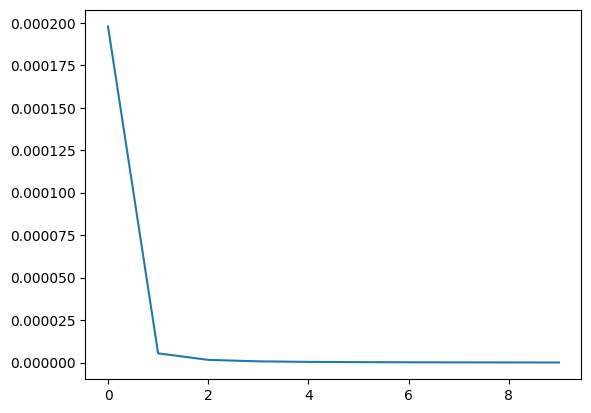

In [4]:
plt.plot(errors_16)

In [5]:
num_qubits = 10
t = 0.1
exact_operator = expm(1.j * t * xy_ham(num_qubits))
errors_16 = []
for i in tqdm(range(1,50,5)):
    evolution_operator = xy_mpo(num_qubits,t,num_trotter_layers=i,max_dim=16)
    errors_16.append(1-np.trace(exact_operator.conj().T @ evolution_operator.to_matrix()).real/(2**num_qubits))

100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.56s/it]


In [30]:
num_qubits = 10
t = 0.1
exact_operator = expm(1.j * t * xy_ham(num_qubits))
errors_64 = []
for i in tqdm(range(1,50,5)):
    evolution_operator = xy_mpo(num_qubits,t,num_trotter_layers=i,max_dim=64)
    errors_64.append(np.linalg.norm(exact_operator - evolution_operator.to_matrix()))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.82s/it]


In [6]:
errors_16#, errors_64

[0.0007870037051582734,
 2.1696355080425e-05,
 6.454136801448129e-06,
 3.0504850236923176e-06,
 1.7707806734268416e-06,
 1.15519156629329e-06,
 8.125981082462985e-07,
 6.025503633821927e-07,
 4.645472895248304e-07,
 3.6904717903851747e-07]

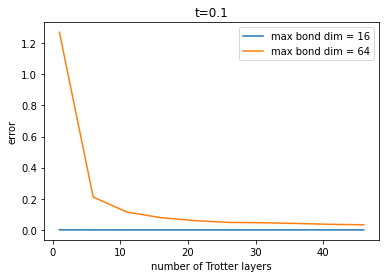

In [32]:
plt.plot(np.arange(1,50,5), errors_16, label='max bond dim = 16')
plt.plot(np.arange(1,50,5), errors_64, label='max bond dim = 64')
plt.xlabel('number of Trotter layers')
plt.ylabel('error')
plt.title('t=0.1')
plt.legend(loc='best')

In [7]:
# for a fixed bond dimension and t what if I increase system size?
max_dim = 20
t = 0.1

min_err = []
min_err_normalized = []
opt_r = []
for num_qubits in range(2,12,2):
    exact_operator = expm(1.j * t * xy_ham(num_qubits))
    errors_20 = []
    for i in tqdm(range(1,10,2)):
        evolution_operator = xy_mpo(num_qubits,t,num_trotter_layers=i,max_dim=20)
        errors_20.append(np.linalg.norm(exact_operator - evolution_operator.to_matrix()))
        
    err = min(errors_20)
    min_err.append(err)
    min_err_normalized.append(err/np.linalg.norm(exact_operator))
    opt_r.append(np.arange(1,50,2)[errors_20.index(err)])
    
    
    print(min_err[-1], min_err_normalized[-1] ,opt_r[-1])

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 224.25it/s]


1.3322676295501878e-15 6.661338147750939e-16 1


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 93.07it/s]


0.008815300822119855 0.0022038252055299637 9


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 17.71it/s]


0.02487175383845477 0.0031089692298068464 9


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]


0.0608726320643608 0.0038045395040225503 9


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]

0.14052096162736138 0.00439128005085505 9


Text(0.5, 0, 'number of qubits')

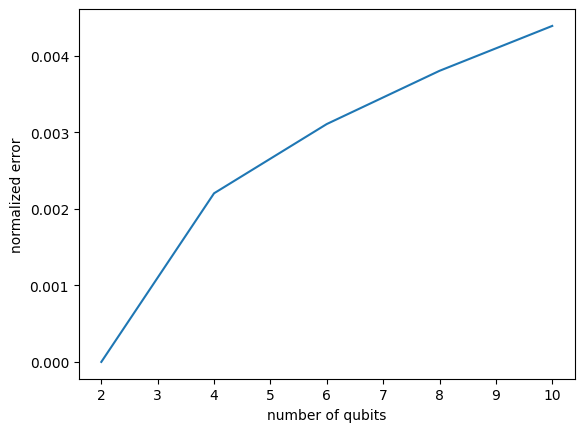

In [8]:
plt.plot(np.arange(2,12,2), min_err_normalized)
plt.ylabel('normalized error')
plt.xlabel('number of qubits')

In [9]:
# using large bond dimension MPO as a benchmark to find optimal r
num_qubits = 10
t = 0.1
benchmark_mpo = xy_mpo(num_qubits, t, num_trotter_layers=20, max_dim=100)

In [10]:
errors_16 = []
for i in tqdm(range(1,12,2)):
    evolution_operator = xy_mpo(num_qubits,t,num_trotter_layers=i,max_dim=16)
    errors_16.append(1-(evolution_operator.conj() @ benchmark_mpo).normalized_trace().real)

  0%|                                                     | 0/6 [00:00<?, ?it/s]


AttributeError: 'MPO' object has no attribute 'normalized_trace'

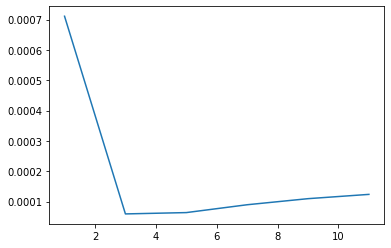

In [41]:
plt.plot(np.arange(1,12,2), errors_16)

In [45]:
# if we already have the benchmark_mpo, why not truncate it? does it give worse result than truncating while constructing mpo?
truncated_benchmark_mpo = benchmark_mpo.compress_symmetric(max_dim=16)
print(1-(truncated_benchmark_mpo.conj() @ benchmark_mpo).normalized_trace().real)

0.5284167762721639


In [46]:
np.linalg.norm(truncated_benchmark_mpo.to_matrix() - exact_operator) / (2**(num_qubits+1))

0.011357806324581735

In [47]:
evolution_operator = xy_mpo(num_qubits,t,num_trotter_layers=3,max_dim=16)
np.linalg.norm(evolution_operator.to_matrix() - exact_operator) / (2**(num_qubits+1))

0.00021609102980783517

In [ ]:
### future developments: higher order Trotter (easy to implement) and Taylor expansion

# Givens Ansatz

In [2]:
num_qubits = 4
t = 0.1
angles = np.random.rand(num_qubits) * 2 * np.pi
layer_params = np.random.rand(num_qubits-1) * 2*np.pi
d = Rotation_MPO(t, angles)
even_stack, odd_stack = Brickwall_MPO(layer_params[0:num_qubits//2], 0), Brickwall_MPO(layer_params[num_qubits//2:num_qubits-1], 1)
d.skeleton, even_stack.skeleton, odd_stack.skeleton

([(1, 1, 2, 2), (1, 1, 2, 2), (1, 1, 2, 2), (1, 1, 2, 2)],
 [(1, 4, 2, 2), (4, 1, 2, 2), (1, 4, 2, 2), (4, 1, 2, 2)],
 [(1, 1, 2, 2), (1, 4, 2, 2), (4, 1, 2, 2), (1, 1, 2, 2)])

In [4]:
num_w_layers = 2
params = np.random.rand(num_w_layers, num_qubits-1)
ansatz = Ansatz(t, angles, params)
ansatz.param_mpo_stacks

In [5]:
ansatz_mat = ansatz.mpo().to_matrix()
actual_mpos = ansatz.param_mpo_stacks

actual_mats = [mpo.to_matrix() for mpo in actual_mpos]
w = actual_mats[4] @ actual_mats[3] @ actual_mats[2] @ actual_mats[1]
ansatz_mat_actual = w @ actual_mats[0] @ w.conj().T
np.linalg.norm(ansatz_mat - ansatz_mat_actual)

7.921371667627419e-15

In [6]:
w_mpo = actual_mpos[4] @ actual_mpos[3] @ actual_mpos[2] @ actual_mpos[1]
np.linalg.norm(ansatz.mpo().to_matrix() - (w_mpo @ actual_mpos[0] @ w_mpo.conj()).to_matrix())

8.301691874513868e-15

# General Ansatz

In [7]:
num_qubits = 4
t = 0.1
angles = np.random.rand(num_qubits) * 2 * np.pi
layer_params = np.random.rand(num_qubits-1,15) * 2*np.pi
d = Rotation_MPO(t, angles)
even_stack, odd_stack = Brickwall_MPO(layer_params[0:num_qubits//2], 0), Brickwall_MPO(layer_params[num_qubits//2:num_qubits-1], 1)
d.skeleton, even_stack.skeleton, odd_stack.skeleton

([(1, 1, 2, 2), (1, 1, 2, 2), (1, 1, 2, 2), (1, 1, 2, 2)],
 [(1, 4, 2, 2), (4, 1, 2, 2), (1, 4, 2, 2), (4, 1, 2, 2)],
 [(1, 1, 2, 2), (1, 4, 2, 2), (4, 1, 2, 2), (1, 1, 2, 2)])

In [8]:
num_w_layers = 2
params = np.random.rand(num_w_layers, num_qubits-1, 15)
ansatz = Ansatz(t, angles, params)
ansatz.param_mpo_stacks

In [9]:
ansatz_mat = ansatz.mpo().to_matrix()
actual_mpos = ansatz.param_mpo_stacks

actual_mats = [mpo.to_matrix() for mpo in actual_mpos]
w = actual_mats[4] @ actual_mats[3] @ actual_mats[2] @ actual_mats[1]
ansatz_mat_actual = w @ actual_mats[0] @ w.conj().T
np.linalg.norm(ansatz_mat - ansatz_mat_actual)

2.2400451819114726e-14

In [10]:
w_mpo = actual_mpos[4] @ actual_mpos[3] @ actual_mpos[2] @ actual_mpos[1]
np.linalg.norm(ansatz.mpo().to_matrix() - (w_mpo @ actual_mpos[0] @ w_mpo.conj()).to_matrix())

2.2693286638488284e-14

In [11]:
ansatz.param_mpo_stacks[1].nodes[0].data

array([[[[-0.60425183+0.0347535j ,  0.25841985+0.25863314j],
         [-0.30354003-0.20380228j, -0.08220996-0.59964123j]],

        [[ 0.03462339-0.6647746j , -0.16366957+0.17345956j],
         [-0.16946908+0.16779803j, -0.6637484 +0.05061726j]],

        [[ 0.04916656+0.23328639j, -0.3178323 +0.58492969j],
         [ 0.05746338+0.66321797j,  0.1383363 -0.19417249j]],

        [[-0.25858304-0.25853973j,  0.03445197-0.60423926j],
         [ 0.32957862+0.50761201j,  0.09632521-0.35274557j]]]])

# Givens environments

## Stack environments 

In [5]:
num_qubits = 4
t = 0.1
num_w_layers = 4
angles = np.random.rand(num_qubits) * 2 * np.pi
params = np.random.rand(num_w_layers, num_qubits-1)
ansatz = Ansatz(t, angles, params)
target_mpo = xy_mpo(num_qubits, t, 5)

In [6]:
# testing environment of rz stack (noiseless)
stack_idx = 0
env1, env2 = stack_env(ansatz, target_mpo, stack_idx)
env1.mult_and_trace(ansatz.param_mpo_stacks[0])[0,0,0,0] - np.trace(ansatz.mpo().to_matrix() @ target_mpo.conj().to_matrix())/(2**num_qubits)

(-5.329070518200751e-15+2.192690473634684e-15j)

In [7]:
# testing environment of givens stacks (noiseless)
for stack_idx in range(1, ansatz.num_stacks):
    env1, env2 = stack_env(ansatz, target_mpo, stack_idx)
    print((env1 @ ansatz.param_mpo_stacks[stack_idx] @ env2 @ ansatz.param_mpo_stacks[stack_idx].conj()).trace() - np.trace(ansatz.mpo().to_matrix() @ target_mpo.conj().to_matrix())/(2**num_qubits))

(-6.439293542825908e-15+2.1718737919229625e-15j)
(-5.773159728050814e-15+2.3800406090401793e-15j)
(-3.552713678800501e-15+2.033095913844818e-15j)
(-2.220446049250313e-15+2.1441182163073336e-15j)
(-1.9984014443252818e-15+1.5474275506799362e-15j)
(1.1102230246251565e-16-4.537386091851836e-17j)
(-3.3306690738754696e-16-3.469446951953614e-17j)
(-2.220446049250313e-16-1.0408340855860843e-16j)


In [8]:
# testing environment of rz stack (noisy)
stack_idx = 0
max_dim = 10
env1, env2 = stack_env(ansatz, target_mpo, stack_idx, max_dim=max_dim)
env1.mult_and_trace(ansatz.param_mpo_stacks[0])[0,0,0,0] - np.trace(ansatz.mpo().to_matrix() @ target_mpo.conj().to_matrix())/(2**num_qubits)

(0.0012797137196201014+0.0002938839335088206j)

In [9]:
# testing environment of givens stacks (noiseless)
max_dim = 10
for stack_idx in range(1, ansatz.num_stacks):
    env1, env2 = stack_env(ansatz, target_mpo, stack_idx, max_dim=max_dim)
    print((env1 @ ansatz.param_mpo_stacks[stack_idx] @ env2 @ ansatz.param_mpo_stacks[stack_idx].conj()).trace() - np.trace(ansatz.mpo().to_matrix() @ target_mpo.conj().to_matrix())/(2**num_qubits))

(0.0012797137196201014+0.0002938839335087616j)
(0.0012552702765098456+0.0002697738970225197j)
(0.0012623316642313975+0.00029758435312850565j)
(0.0010971666880974507+0.00029758675623800523j)
(0.001182107949659894+0.0002741919999254713j)
(0.00020943124704220217+1.0828842789728467e-05j)
(0.0002536071897488723-1.3037121658905637e-05j)
(0.00019259602843901824-5.246590258026901e-05j)


## Building environments from left and right 

In [15]:
num_qubits = 4
num_w_layers = 4
t = 0.1

angles = np.asarray(np.random.rand(num_qubits))
params = np.asarray(np.random.rand(num_w_layers, num_qubits-1)) 
ansatz = Ansatz(t, angles, params)
num_trotter_steps = 5
target_mpo = xy_mpo(num_qubits, t, num_trotter_steps)

In [16]:
left_envs, right_envs = all_stack_envs(ansatz, target_mpo)
for i in range(1, ansatz.num_stacks): 
    old_stack_idx = i
    target_stack_idx = old_stack_idx - 1
    num_stacks = ansatz.num_stacks
    cur_right_env = right_envs[old_stack_idx]
    new_stack = ansatz.param_mpo_stacks[old_stack_idx]
    new_env = build_right_env(cur_right_env, new_stack)
    print(np.linalg.norm(new_env.to_matrix() - right_envs[target_stack_idx].to_matrix()))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [17]:
for old_stack_idx in range(ansatz.num_stacks-1): 
    target_stack_idx = old_stack_idx + 1
    num_stacks = ansatz.num_stacks
    cur_left_env = left_envs[old_stack_idx]
    new_stack = ansatz.param_mpo_stacks[old_stack_idx]
    new_env = build_left_env(cur_left_env, new_stack)
    print(np.linalg.norm(new_env.to_matrix() - left_envs[target_stack_idx].to_matrix()))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


## Node environments

In [4]:
num_qubits = 6
t = 0.1
num_w_layers = 2
angles = np.random.rand(num_qubits) * 2 * np.pi
params = np.random.rand(num_w_layers, num_qubits-1)
ansatz = Ansatz(t, angles, params)
target_mpo = xy_mpo(num_qubits, t, 5)
true_trace = ansatz.mpo().mult_and_trace(target_mpo.conj())[0,0,0,0]
true_trace

(0.9250453125007135-2.942091015256665e-15j)

In [3]:
stack_idx = 0
param_mpo = ansatz.param_mpo_stacks[stack_idx]
stack_env1, stack_env2 = stack_env(ansatz, target_mpo, stack_idx)
for node_idx in range(num_qubits):
    top_env, bottom_env = node_semi_env(param_mpo, stack_idx, node_idx, stack_env1, stack_env2)
    f_env = full_env(stack_env1.nodes[node_idx].data, None, top_env, bottom_env)
    print(np.einsum('ij,ij->', f_env, param_mpo.nodes[node_idx].data[0,0]) - true_trace)

(-1.3322676295501878e-15+4.163336342344337e-16j)
(-1.1102230246251565e-15+4.440892098500626e-16j)
(-1.1102230246251565e-15+2.914335439641036e-16j)
(-8.881784197001252e-16+3.122502256758253e-16j)
(-1.1102230246251565e-15+3.7470027081099033e-16j)
(-8.881784197001252e-16+3.608224830031759e-16j)


In [4]:
for stack_idx in range(1,ansatz.num_stacks): 
    param_mpo = ansatz.param_mpo_stacks[stack_idx]
    stack_env1, stack_env2 = stack_env(ansatz, target_mpo, stack_idx)

    for node_idx in range(num_qubits//2 - (stack_idx+1)%2):
        top_env, bottom_env = node_semi_env(param_mpo, stack_idx, node_idx, stack_env1, stack_env2)

        idx = 2*node_idx+(stack_idx+1)%2
        link_data1 = nodes_to_supernode(stack_env1.nodes[idx], stack_env1.nodes[idx+1])
        link_data2 = nodes_to_supernode(stack_env2.nodes[idx], stack_env2.nodes[idx+1]) if stack_env2 is not None else None
        f_env = full_env(link_data1, link_data2, top_env, bottom_env)

        param_data = nodes_to_gate(param_mpo.nodes[idx], param_mpo.nodes[idx+1])
        first = np.tensordot(f_env, param_data, axes=([2,7,0,5],[0,1,2,3]))
        second = np.tensordot(first, param_data.conj(), axes=([2,0,3,1],[0,1,2,3]))
        print(second-true_trace)

(-5.551115123125783e-16+7.91033905045424e-16j)
(-6.661338147750939e-16+7.563394355258879e-16j)
(-6.661338147750939e-16+7.91033905045424e-16j)
(-3.219646771412954e-15+6.661338147750939e-16j)
(-3.1086244689504383e-15+6.522560269672795e-16j)
(-8.881784197001252e-16+3.3306690738754696e-16j)
(-8.881784197001252e-16+2.636779683484747e-16j)
(-8.881784197001252e-16+1.8041124150158794e-16j)
-3.0531133177191805e-16j
(2.220446049250313e-16-8.326672684688674e-17j)


In [5]:
for stack_idx in range(1,ansatz.num_stacks): 
    param_mpo = ansatz.param_mpo_stacks[stack_idx]
    stack_env1, stack_env2 = stack_env(ansatz, target_mpo, stack_idx)

    for node_idx in range(num_qubits//2 - (stack_idx+1)%2):
        n_env = node_env(param_mpo, stack_idx, node_idx, stack_env1, stack_env2)        
        idx = 2*node_idx+(stack_idx+1)%2
        param_data = nodes_to_gate(param_mpo.nodes[idx], param_mpo.nodes[idx+1])        
        first = np.tensordot(n_env, param_data, axes=([2,7,0,5],[0,1,2,3]))
        second = np.tensordot(first, param_data.conj(), axes=([2,0,3,1],[0,1,2,3]))
        print(second-true_trace)

(-5.551115123125783e-16+7.91033905045424e-16j)
(-6.661338147750939e-16+7.563394355258879e-16j)
(-6.661338147750939e-16+7.91033905045424e-16j)
(-3.219646771412954e-15+6.661338147750939e-16j)
(-3.1086244689504383e-15+6.522560269672795e-16j)
(-8.881784197001252e-16+3.3306690738754696e-16j)
(-8.881784197001252e-16+2.636779683484747e-16j)
(-8.881784197001252e-16+1.8041124150158794e-16j)
-3.0531133177191805e-16j
(2.220446049250313e-16-8.326672684688674e-17j)


In [6]:
for stack_idx in range(1,ansatz.num_stacks): 
    param_mpo = ansatz.param_mpo_stacks[stack_idx]
    stack_env1, stack_env2 = stack_env(ansatz, target_mpo, stack_idx)
    bottom_envs, top_envs = all_node_envs(param_mpo, stack_idx, stack_env1, stack_env2)
    for node_idx in range(num_qubits//2 - (stack_idx+1)%2):
        top_env, bottom_env = top_envs[node_idx], bottom_envs[node_idx]

        idx = 2*node_idx+(stack_idx+1)%2
        link_data1 = nodes_to_supernode(stack_env1.nodes[idx], stack_env1.nodes[idx+1])
        link_data2 = nodes_to_supernode(stack_env2.nodes[idx], stack_env2.nodes[idx+1]) if stack_env2 is not None else None
        f_env = full_env(link_data1, link_data2, top_env, bottom_env)
        
        param_data = nodes_to_gate(param_mpo.nodes[idx], param_mpo.nodes[idx+1])
        first = np.tensordot(f_env, param_data, axes=([2,7,0,5],[0,1,2,3]))
        second = np.tensordot(first, param_data.conj(), axes=([2,0,3,1],[0,1,2,3]))
        print(second-true_trace)

(-5.551115123125783e-16+7.91033905045424e-16j)
(-6.661338147750939e-16+7.563394355258879e-16j)
(-6.661338147750939e-16+7.91033905045424e-16j)
(-3.219646771412954e-15+6.661338147750939e-16j)
(-3.1086244689504383e-15+6.522560269672795e-16j)
(-8.881784197001252e-16+3.3306690738754696e-16j)
(-8.881784197001252e-16+2.636779683484747e-16j)
(-8.881784197001252e-16+1.8041124150158794e-16j)
-3.0531133177191805e-16j
(2.220446049250313e-16-8.326672684688674e-17j)


# Optimization

## Node cost and derivative 

In [2]:
num_qubits = 4
num_w_layers = 4
t = 0.1

angles = np.asarray(np.random.rand(num_qubits))
params = np.asarray(np.random.rand(2*num_w_layers+1, 3*num_qubits)) 
ansatz = Ansatz(t, angles, params)
num_trotter_steps = 5
target_mpo = xy_mpo(num_qubits, t, num_trotter_steps)

In [3]:
# does node_cost product correct cost function in rz stack
stack_idx = 0
stack_env1, stack_env2 = stack_env(ansatz, target_mpo, stack_idx)
stack_params = ansatz.angles
true_cost = 1 - (target_mpo.conj() @ ansatz.mpo()).trace().real

for node_idx in range(num_qubits):
    n_env = node_env(ansatz.param_mpo_stacks[stack_idx], node_idx, stack_env1)
    print(node_cost(ansatz.angles[node_idx], n_env, t) - true_cost)

1.7763568394002505e-15
1.6653345369377348e-15
1.3322676295501878e-15
1.3322676295501878e-15


In [4]:
# does node_cost produce correct cost function in general stack
for stack_idx in range(1, ansatz.num_stacks): 
    stack_env1, stack_env2 = stack_env(ansatz, target_mpo, stack_idx)
    stack_params = ansatz.params[stack_idx-1]

    for node_idx in range(num_qubits):
        node_idx = 3
        n_env = node_env(ansatz.param_mpo_stacks[stack_idx], node_idx, stack_env1, stack_env2)
        print(node_cost(ansatz.params[stack_idx-1][node_idx*3:(node_idx+1)*3], n_env, t) - true_cost)

2.220446049250313e-15
2.220446049250313e-15
2.220446049250313e-15
2.220446049250313e-15
0.0
0.0
0.0
0.0
1.9984014443252818e-15
1.9984014443252818e-15
1.9984014443252818e-15
1.9984014443252818e-15
0.0
0.0
0.0
0.0
4.440892098500626e-16
4.440892098500626e-16
4.440892098500626e-16
4.440892098500626e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
-2.1094237467877974e-15
-2.1094237467877974e-15
-2.1094237467877974e-15
-2.1094237467877974e-15
-1.5543122344752192e-15
-1.5543122344752192e-15
-1.5543122344752192e-15
-1.5543122344752192e-15
-4.440892098500626e-16
-4.440892098500626e-16
-4.440892098500626e-16
-4.440892098500626e-16


In [5]:
# does rz_node_deriv reproduce fd
stack_idx = 0
stack_env1, stack_env2 = stack_env(ansatz, target_mpo, stack_idx)

for node_idx in range(num_qubits):
    n_env = node_env(ansatz.param_mpo_stacks[stack_idx], node_idx, stack_env1)
    fd = node_grad_fd(ansatz.angles[node_idx], n_env, t)
    exact = rz_node_deriv(n_env, ansatz.angles[node_idx], t)
    print(fd-exact)

[5.50506635e-14]
[-2.12769038e-13]
[-6.65709675e-13]
[-2.66962342e-13]


In [6]:
# does general_node_deriv reproduce fd
for stack_idx in range(1,ansatz.num_stacks):
    stack_env1, stack_env2 = stack_env(ansatz, target_mpo, stack_idx)

    for node_idx in range(num_qubits):
        n_env = node_env(ansatz.param_mpo_stacks[stack_idx], node_idx, stack_env1, stack_env2)
        fd = node_grad_fd(ansatz.params[stack_idx-1][node_idx*3:(node_idx+1)*3], n_env)
        exact = general_node_deriv(n_env, ansatz.params[stack_idx-1][node_idx*3:(node_idx+1)*3])
        print(fd-exact)

[-1.0186341e-08  6.2864274e-09  4.6857167e-09]
[ 2.5611371e-09 -3.3527058e-08 -2.6793714e-08]
[1.5716068e-08 1.3038516e-08 1.3882527e-08]
[6.09725248e-09 1.12917311e-08 1.02154445e-08]
[-2.6193447e-10 -1.4260877e-09 -2.3283064e-09]
[ 1.3969839e-09 -1.1670636e-08 -1.1597876e-08]
[ 4.2336978e-10  9.7206794e-09 -1.2572855e-08]
[-1.9586878e-08 -2.6433554e-08  1.2078090e-09]
[-9.0767571e-09  9.8370947e-09  1.7378625e-08]
[-3.2014214e-09 -1.4591478e-08 -2.4505425e-08]
[-1.0419171e-08  3.7834980e-10  1.8189894e-09]
[-1.0768417e-09 -1.1787051e-09 -1.0186341e-10]
[-7.1304385e-10  1.0804797e-09  1.2769306e-09]
[-2.8521754e-09 -3.5281118e-08  1.9281288e-09]
[-1.4260877e-09 -1.7986167e-08 -5.7043508e-09]
[-1.1641532e-08 -1.2892997e-08 -2.5436748e-08]
[4.4819899e-09 7.3341653e-09 3.2676326e-08]
[ 2.4476321e-08 -3.4808181e-08 -1.7520506e-08]
[-4.04106686e-08 -1.29657565e-08 -1.16415322e-08]
[-1.2005330e-08 -4.6275090e-09  5.1077222e-09]
[ 4.8021320e-09 -2.0081643e-09  3.3323886e-09]
[ 2.0954758e-09 

## Node optimizer

In [7]:
num_qubits = 4
num_w_layers = 4
t = 0.1

angles = np.asarray(np.random.rand(num_qubits))
params = np.asarray(np.random.rand(2*num_w_layers+1, 3*num_qubits)) 
ansatz = Ansatz(t, angles, params)
num_trotter_steps = 5
target_mpo = xy_mpo(num_qubits, t, num_trotter_steps)

In [8]:
# optimizing all nodes
for stack_idx in range(ansatz.num_stacks):
    stack_env1, stack_env2 = stack_env(ansatz, target_mpo, stack_idx)
    for node_idx in range(num_qubits):
        n_env = node_env(ansatz.param_mpo_stacks[stack_idx], node_idx, stack_env1, stack_env2)
        new_cost, new_node = node_optimizer(ansatz, stack_idx, node_idx, n_env, t)
        print(new_cost)

0.03214676657905424
0.03195002956228565
0.03171432860975343
0.02986356529762879
0.029858865418667335
0.02985444707051621
0.02985310050860801
0.029853098477471418
0.02984545302692676
0.02978834569306077
0.02976011795220479
0.029758780204131585
0.029730110357894524
0.029632100130416728
0.029622272817393602
0.02961677141646568
0.029611074972793472
0.02957920799476832
0.02952771204689586
0.029519583187220477
0.029514503370869694
0.02941544103234317
0.02938772649724708
0.029383516982059543
0.02936164660817675
0.02929311677768598
0.02924411702742058
0.02922380858050244
0.02921445891587049
0.029159459123240694
0.029123362553839627
0.02911741117988509
0.029101608781430643
0.02907723615971447
0.029064291456581515
0.0290557840585135
0.02904365656510044
0.02902529950064614
0.029013296535242317
0.029002550632829527


In [9]:
# testing sweep_up_down
for stack_idx in range(ansatz.num_stacks): 
    param_mpo = ansatz.param_mpo_stacks[stack_idx]
    stack_env1, stack_env2 = stack_env(ansatz, target_mpo, stack_idx)
    link_datas1 = [stack_env1.nodes[node_idx].data for node_idx in range(ansatz.num_qubits)]
    link_datas2 = [None] * ansatz.num_qubits if stack_env2 is None else [stack_env2.nodes[node_idx].data for node_idx in range(ansatz.num_qubits)]
    bottom_envs, top_envs = all_node_envs(param_mpo, stack_env1, stack_env2)
    cost_list = sweep_up_down(ansatz, stack_idx, bottom_envs, top_envs, link_datas1, link_datas2, t)
    print(cost_list[0], cost_list[-1])

0.028646183521946145 0.027736562986004576
0.027734442258978476 0.027542469734874286
0.027525111073030573 0.027270040032685294
0.02725736391307154 0.02666324953221566
0.026623040003376564 0.02653299816902721
0.026476898097764767 0.02606407985884207
0.026062751958044972 0.025870234350243382
0.02570331030028017 0.02533107020571146
0.02530782202350368 0.025216497381447045
0.025193903630758574 0.02506184660024291


## Nodewise training 

In [2]:
num_qubits = 4
num_w_layers = 4
t = 0.1
num_trotter_steps = 5
noisy_cost_data, exact_cost_data, time_data, angles, params = nodewise_train(num_qubits, t, num_trotter_steps, num_w_layers, num_stack_sweeps=10, max_dim=16)

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.01it/s]

 10%|████████▎                                                                          | 1/10 [00:03<00:34,  3.83s/it]

0.026173246310755793



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.09it/s]

 20%|████████████████▌                                                                  | 2/10 [00:07<00:30,  3.79s/it]

0.01575171913363227



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.16it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:11<00:27,  3.96s/it]

0.012566580753105239



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.25it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:15<00:22,  3.70s/it]

0.00978511989544828



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.58it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:18<00:18,  3.73s/it]

0.008275528369927065



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.06it/s]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:22<00:14,  3.70s/it]

0.007247310822087183



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.94it/s]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:26<00:11,  3.76s/it]

0.006504148249460107



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.11it/s]

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:31<00:08,  4.06s/it]

0.006010998430703185



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  4.85it/s]

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:35<00:04,  4.18s/it]

0.005689390962225205



100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.02s/it]

0.005461347418336926


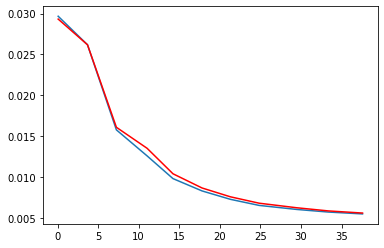

In [11]:
plt.plot(time_data[0::17], exact_cost_data)
plt.plot(time_data[0::17], noisy_cost_data[0::17], 'r')

# Timing

In [2]:
%load_ext line_profiler

In [3]:
num_qubits = 12
num_w_layers = num_qubits 
max_dim = 64
num_trotter_steps = 5
t=0.1

In [4]:
%lprun -f nodewise_train nodewise_train(num_qubits, t, num_trotter_steps, num_w_layers, num_stack_sweeps=10, max_dim=64, testing=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:42<00:00,  1.70s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:40<00:00,  1.62s/it]

 52%|███████████████████████████████████████████████████████████████████▌                                                              | 13/25 [00:23<00:20,  1.74s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:40<00:00,  1.62s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:41<00:00,  1.65s/it]

  4%|█████▏                                                                                                                             | 1/25 [00:01<00:31,  1.32s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:44<00:00,  1.77s/it]

 60%|██████████████████████████████████████████████████████████████████████████████                                                    | 15/25 [00:24<00:19,  1.90s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:44<00:00,  1.79s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:47<00:00,  1.90s/it]

 12%|███████████████▋                                                                                                                   | 3/25 [00:03<00:27,  1.27s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:49<00:00,  1.99s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:49<00:00,  1.98s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 18/25 [00:51<00:21,  3.02s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:13<00:00,  2.93s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [16:41<00:00, 100.11s/it]


In [8]:
angles = np.zeros(num_qubits)
params = np.random.rand(2*num_w_layers+1, 3*num_qubits) * 2*np.pi
ansatz = Ansatz(t, angles, params)
target_mpo = xy_mpo(num_qubits, t, num_trotter_steps, max_dim=max_dim)
left_envs, right_envs = all_stack_envs(ansatz, target_mpo, max_dim=max_dim)

stack_idx = 8
stack_env1, stack_env2 = right_envs[stack_idx], left_envs[stack_idx]
param_mpo = ansatz.param_mpo_stacks[stack_idx]
bottom_envs, top_envs = all_node_envs(param_mpo, stack_env1, stack_env2)
link_datas1 = [stack_env1.nodes[i].data for i in range(num_qubits)]
link_datas2 = [None]*num_qubits if stack_env2 is None else [stack_env2.nodes[i].data for i in range(num_qubits)]

In [9]:
%lprun -f sweep_up_down sweep_up_down(ansatz, stack_idx, bottom_envs, top_envs, link_datas1, link_datas2, t)

# Test runs

## Can I compile identity? 

In [ ]:
num_qubits = 4
target_mpo = MPO([Node(jnp.eye(2,2)[jnp.newaxis,jnp.newaxis,:,:]) for i in range(num_qubits)])
t = 0.1 # doesn't really matter since angles should equal zero
num_w_layers = 1
angles = jnp.asarray(np.random.rand(num_qubits)) 
params = jnp.asarray(np.random.rand(2*num_w_layers+1, 3*num_qubits)) # doesn't really matter once angles << 1 
ansatz = Ansatz(t, angles, params)
min_sv_ratio = None
max_dim = None

In [ ]:
1-(ansatz.mpo().conj() @ target_mpo).normalized_trace() 

In [ ]:
env = ansatz.deriv_mpo(target_mpo, 0, min_sv_ratio, max_dim)
angles = ansatz.angles
print(angles)
new_cost_list, angles = optimizer(d_cost, d_cost_grad, angles, env, t, max_iter=200)
ansatz.update(0, angles)
print(angles)
print(new_cost_list[-1])

In [ ]:
param_idx_left = np.arange(ansatz.num_stacks-1)
for i in tqdm(range(ansatz.num_stacks-1)): 
    choice = np.random.randint(len(param_idx_left))
    param_idx = param_idx_left[choice]
    param_idx_left = np.delete(param_idx_left, choice)
    stack_idx = param_idx + 1
    
    env1, env2 = ansatz.deriv_mpo(target_mpo, stack_idx)
    stack_params = ansatz.params[param_idx]
    print(stack_params)
    new_cost_list, stack_params = optimizer(layer_cost, layer_cost_grad, stack_params, env1, env2, max_iter=50)
    ansatz.update(stack_idx, stack_params)
    print(stack_params)
    print(new_cost_list[-1])

In [ ]:
env = ansatz.deriv_mpo(target_mpo, 0, min_sv_ratio, max_dim)
angles = ansatz.angles
print(angles)
new_cost_list, angles = optimizer(d_cost, d_cost_grad, angles, env, t, max_iter=500)
ansatz.update(0, angles)
print(angles)
print(new_cost_list[-1])

In [ ]:
env = ansatz.deriv_mpo(target_mpo, 0, min_sv_ratio, max_dim)
angles = ansatz.angles
print(angles)
new_cost_list, angles = optimizer(d_cost, d_cost_grad, angles, env, t, max_iter=500)
ansatz.update(0, angles)
print(angles)
print(new_cost_list[-1])

In [ ]:
# this doesn't have to be identity because the diagonal portion is 
(ansatz.odd_mpo @ ansatz.param_mpo_stacks[1] @ ansatz.odd_mpo).to_matrix()

## 2 qubit simulation (no max_dim, no min_sv_ratio) 

In [ ]:
num_qubits = 2
t=0.1
num_trotter_layers = 5
num_w_layers = 1
cost_list1, angles1, params_array1 = train(num_qubits, t, num_trotter_layers, num_w_layers=num_w_layers, num_steps=100, eta=10)

In [ ]:
cost_list2, angles2, params_array2 = train(num_qubits, t, num_trotter_layers, num_w_layers=num_w_layers, num_steps=100, eta=10, angles=angles1, params_array=params_array1)

In [ ]:
cost_list3, angles3, params_array3 = train(num_qubits, t, num_trotter_layers, num_w_layers=num_w_layers, num_steps=100, eta=10, angles=angles2, params_array=params_array2)

In [ ]:
plt.plot(cost_list1+cost_list2+cost_list3)
plt.yscale('log')

## 2 qubit simulation (finite differences, no max_dim, no min_sv_ratio) 

In [ ]:
num_qubits = 2
t=0.1
num_trotter_layers = 5
num_w_layers = 1
cost_list1, angles1, params_array1 = train(num_qubits, t, num_trotter_layers, num_w_layers=num_w_layers, num_steps=100, eta=10)

In [ ]:
cost_list2, angles2, params_array2 = train(num_qubits, t, num_trotter_layers, num_w_layers=num_w_layers, num_steps=100, eta=10, angles=angles1, params_array=params_array1)

## 4 qubit simulation 

In [ ]:
num_qubits = 6
t = 0.1
num_w_layers = 6
num_trotter_steps = 5
angles = np.asarray(np.random.rand(num_qubits)) 
params = np.asarray(np.random.rand(2*num_w_layers+1, 3*num_qubits)) 
train(num_qubits, t, num_trotter_steps, num_w_layers)

# Known problem 1: Initializing from identity

In [ ]:
# initializing the ansatz as identity
num_qubits = 6
t=0.1
angles = jnp.zeros(num_qubits)
params_array = jnp.zeros((num_qubits-1, 15))
a = ansatz_mpo(t, angles, params_array, min_sv_ratio=0.1)
a.to_matrix()

In [ ]:
# test derivatives
num_qubits=6
t=0.5
num_trotter_layers = 4
angles =jnp.zeros(num_qubits)+0.1
angles = angles.at[0].set(0.0)
angles = angles.at[1].set(0.0)
angles = angles.at[2].set(0.0)
angles = angles.at[3].set(0.0)
angles = angles.at[4].set(0.0)
angles = angles.at[5].set(0.0)
target_mpo = xy_mpo(num_qubits, t, num_trotter_layers, max_dim=16)
def angle_cost(target_mpo, t, angles):
    ''' ||target_mpo - ansatz_mpo|| / 2^(n+1) '''
    return 1 - (target_mpo.conj() @ D_Layer(t, angles)).normalized_trace().real

angle_cost(target_mpo, t, angles)
grad_angle = grad(angle_cost, argnums=(2))
grad_angle(target_mpo, t, angles)

# Stackwise optimization

In [18]:
from stackwise_train import *

## Stack cost and derivative

In [9]:
# test stack_cost for diagonal stack
environment = ansatz.stack_env(target_mpo, 0)
stack_cost(angles, environment, t) - (np.linalg.norm(ansatz.mpo().to_matrix() - target_mpo.to_matrix())**2)/ 32

1.5199647096508784e-14

In [11]:
# test stack_cost for non-diagonal stack
stack_idx = 3
env1, env2 = ansatz.stack_env(target_mpo, stack_idx)
stack_cost(params[stack_idx-1], env1, env2) - (np.linalg.norm(ansatz.mpo().to_matrix() - target_mpo.to_matrix())**2)/ 32

1.5643736306358846e-14

In [17]:
environment = ansatz.stack_env(target_mpo, 0)
stack_grad(angles, environment, t)

array([0.00139768, 0.00201162, 0.0001509 , 0.0005454 ])

In [16]:
# test stack_grad
stack_idx = 3
env1, env2 = ansatz.stack_env(target_mpo, stack_idx)
stack_grad(params[stack_idx-1], env1, env2)

array([-6.96367969e-05,  1.34792196e-04,  3.36436148e-04, -6.18128971e-04,
        1.00152299e-04, -9.90862343e-04,  9.31964751e-04, -1.86763987e-04,
       -1.86482477e-04,  6.50025522e-04,  4.99087839e-04, -5.88299226e-05])

## Stackwise training

In [19]:
num_qubits = 4
t = 0.1
num_trotter_steps = 5
num_w_layers = 4
max_dim = 16
stackwise_train(num_qubits, t, num_trotter_steps, num_w_layers, max_dim=max_dim, num_sweeps=3)

 33%|████████████████████████████                                                        | 1/3 [00:57<01:54, 57.28s/it]

0.028437829940798576 0.028437829940798687


 67%|████████████████████████████████████████████████████████                            | 2/3 [01:36<00:46, 46.44s/it]

0.01013623094504279 0.010136230945042124


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:23<00:00, 47.77s/it]

0.009934937605322158 0.009934937605321714


([0.02963628805198948,
  0.02909621171254617,
  0.02844030529846031,
  0.028437829940798687,
  0.013279325053111801,
  0.010141275324740295,
  0.010140784562254757,
  0.010136230945042124,
  0.009935094595761473,
  0.009934964565686322,
  0.009934947371659897,
  0.009934937605321714],
 [0.02970017378901768,
  0.028437829940798576,
  0.01013623094504279,
  0.009934937605322158],
 array([-1.99170165e-03, -2.83109493e+00,  2.82950320e+00,  2.03000982e-03]),
 array([[-7.83889671e-01,  2.59290634e-02,  4.01991522e-02,
         -8.66898772e-05,  7.35448929e-02,  8.19807973e-02,
         -7.83892892e-01,  4.52516990e-02,  2.00397442e-02,
          3.67470103e-03,  8.03002044e-02,  2.65492511e-02],
        [ 7.35213344e-02, -3.36273900e-02,  8.05239922e-03,
          1.57151173e+00, -1.99996192e-02,  1.03257710e-01,
         -6.99571720e-10,  1.03114351e-03, -1.03114352e-03,
         -3.90368423e-03, -2.35697751e-02,  5.15847619e-02],
        [ 4.46650673e-02,  3.79719731e-02,  7.60365752e-02,

## Stackwise training with noise 

In [20]:
num_qubits = 4
t = 0.1
num_trotter_steps = 5
num_w_layers = 4
max_dim = 4
stackwise_train(num_qubits, t, num_trotter_steps, num_w_layers, max_dim=max_dim, num_sweeps=3)

 33%|████████████████████████████                                                        | 1/3 [00:59<01:59, 59.85s/it]

0.02656562275478591 0.026354173868404107


 67%|████████████████████████████████████████████████████████                            | 2/3 [01:45<00:51, 51.25s/it]

0.01733523887103705 0.017266000011702642


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:27<00:00, 49.08s/it]

0.016199865223630372 0.016128695696956852


([0.028938935904301633,
  0.02714555334746538,
  0.02664754259724278,
  0.026636976617159913,
  0.026610658074240012,
  0.026513539384511287,
  0.026474837153266484,
  0.026451356971541662,
  0.026363845400986463,
  0.026354173868404107,
  0.021055136284950038,
  0.020828673370719475,
  0.019545706690016318,
  0.0195414991155205,
  0.01953797663460244,
  0.01759694186400007,
  0.017373632642255332,
  0.017364576964040035,
  0.017360504914117114,
  0.017266000011702642,
  0.016576424902841946,
  0.01655764374996238,
  0.01641822626519107,
  0.016366496602161718,
  0.016366377214832917,
  0.01632271733345214,
  0.016244871761674995,
  0.0162443915372964,
  0.016194750463895957,
  0.016128695696956852],
 [0.029655916701596174,
  0.02656562275478591,
  0.01733523887103705,
  0.016199865223630372],
 array([ 1.98483550e-03, -1.73023593e+00, -1.77582237e+00,  2.09964163e+00]),
 array([[ 3.54984236e-06,  6.95504610e-03,  7.87134515e-02,
         -6.34672895e-04,  2.94800562e-02,  8.84307754e-0